In [1]:
import MDAnalysis as mda
import os
import glob
import sys

In [2]:
import numpy as np
import pandas as pd
from MDAnalysis.analysis.rdf import InterRDF, InterRDF_s
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150


In [11]:
from pathlib import Path

root = Path('./').resolve()
directories = [str(path.relative_to(root)) for path in root.rglob('*') if path.is_dir() and len(path.relative_to(root).parts) == 2]
print(directories)

['CAHS12-dC/sim_1', 'CAHS12-dC/sim_3', 'CAHS12-dC/sim_2', 'CAHS12/sim_1', 'CAHS12/sim_3', 'CAHS12/sim_2', 'CAHS12-dN/sim_1', 'CAHS12-dN/sim_3', 'CAHS12-dN/sim_2']


In [7]:
for folder in directories:
    command = f'echo 16 | gmx_mpi trjconv -f ./{folder}/md.xtc -s ./{folder}/md.tpr -pbc mol -o ./{folder}/md.gro -dump 1500000 -n ./{folder}/index.ndx'
    os.system(command)

In [8]:
for folder in directories:
    command = f'echo 16 | gmx_mpi trjconv -f ./{folder}/md.gro -s ./{folder}/md.tpr -pbc mol -o ./{folder}/popc_protein.pdb -n ./{folder}/index.ndx -conect yes'
    os.system(command)
    

In [9]:
for folder in directories:
    command = f'echo 16 | gmx_mpi trjconv -f ./{folder}/md.xtc -s ./{folder}/md.tpr -pbc mol \
    -o ./{folder}/popc_protein.xtc -n ./{folder}/index.ndx  -b 1000000 -dt 2000 -e 1500000'
    os.system(command)
    

In [10]:
for folder in directories:
    command = f'echo 5 | gmx_mpi trjconv -f ./{folder}/md.gro -s ./{folder}/md.tpr -pbc mol -trans 0 0 -10 -o ./{folder}/protein_shifted.pdb -n ./{folder}/index.ndx -conect yes'
    os.system(command)
    

In [11]:
for folder in directories:
    command = f'echo 5 | gmx_mpi trjconv -f ./{folder}/md.xtc -s ./{folder}/md.tpr \
    -pbc mol -trans 0 0 -10 -o ./{folder}/protein.xtc -b 1000000 -dt 2000 -e 1500000'
    os.system(command)
    

### COM distance

In [13]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import os

cutoff_xy = 8.0  # Local search radius in XY (Å) -- contains ~ 6 POPC lipids

overall_stats = []

for directory in directories:
    print(f"Processing {directory}...")

    u = mda.Universe(f'./{directory}/popc_protein.pdb',
                     f'./{directory}/popc_protein.xtc')

    protein = u.select_atoms("protein")
    lipid_heads = u.select_atoms("resname POPC and name NC3")

    frame_inserted_counts = []

    for ts in u.trajectory[::5]:
        inserted_count = 0

        for res in protein.residues:
            com = res.atoms.center_of_mass()
            com_xy = com[:2]

            lipid_positions = lipid_heads.positions
            lipid_xy = lipid_positions[:, :2]
            distances_xy = np.linalg.norm(lipid_xy - com_xy, axis=1)

            nearby_z = lipid_positions[distances_xy < cutoff_xy][:, 2]

            if len(nearby_z) < 2:
                continue  # Not enough lipids nearby to define leaflet

            median_z = np.median(nearby_z)
            upper_leaflet = nearby_z[nearby_z > median_z]
            lower_leaflet = nearby_z[nearby_z < median_z]

            if len(upper_leaflet) == 0 or len(lower_leaflet) == 0:
                continue 

            upper_mean = np.mean(upper_leaflet)
            lower_mean = np.mean(lower_leaflet)
            membrane_center = (upper_mean + lower_mean) / 2

            if ((com[2] - membrane_center) > 0 and (com[2] - upper_mean) < 0) or ((com[2] - membrane_center) < 0 and (com[2] - lower_mean) > 0):
                inserted_count += 1

        frame_inserted_counts.append(inserted_count)

    df = pd.DataFrame({
        'frame': np.arange(len(frame_inserted_counts)),
        'inserted_residue_count': frame_inserted_counts
    })
    #df.to_csv(f"{directory}_insertion_local.csv", index=False)
    overall_stats.append((directory, np.mean(frame_inserted_counts)))

# Print overall stats
for name, avg_inserted in overall_stats:
    print(f"{name}: Avg Inserted Residues = {avg_inserted:.2f}")


Processing delta_C-3...


/home/mjianming/miniconda3/envs/ELP/lib/python3.8/site-packages/MDAnalysis/coordinates/XDR.py:241: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


delta_C-3: Avg Inserted Residues = 113.73


In [4]:
def pval_to_star(p):
    if p < 0.0001:
        return '****'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'n.s.'


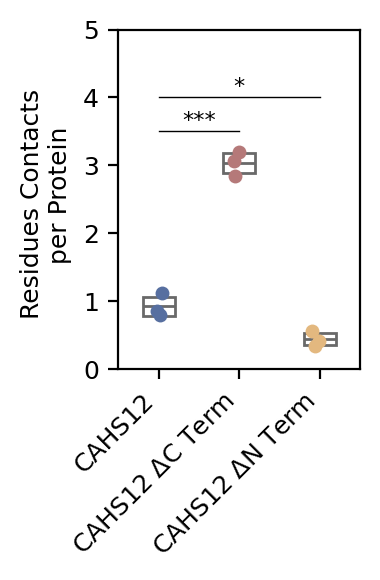

In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.stats import ttest_ind


xnames = ['CAHS12', r'CAHS12 $\Delta$C Term', r'CAHS12 $\Delta$N Term']
data = np.array([
    [34.18, 32.27, 44.82],
    [128.18, 122.91, 113.73],
    [14.00, 17.00, 22.36]
], dtype=float)

data=data/40


group1 = data[0]  # CAHS12
group2 = data[1]  # CAHS12-ΔC
group3 = data[2]  # CAHS12-ΔN

tstat_c, pval_c = ttest_ind(group1, group2, equal_var=False)
tstat_n, pval_n = ttest_ind(group1, group3, equal_var=False)


colors = ['#576fa0', '#b57979', '#e3b87f']
xpos = np.arange(1, 4)
size = 25

means = [np.mean(g) for g in data]
stds = [np.std(g) for g in data]

plt.figure(figsize=(2, 3), dpi=200)
ax = plt.gca()
box_width = 0.4

for x, mean, std, color in zip(xpos, means, stds, colors):
    rect = patches.Rectangle(
        (x - box_width / 2, mean - std),
        width=box_width,
        height=2 * std,
        edgecolor='dimgray',
        facecolor='white',
        linewidth=1.,
        zorder=2
    )
    ax.add_patch(rect)

    plt.hlines(mean, x - box_width / 2, x + box_width / 2,
               color='dimgray', linewidth=1., zorder=3)

for i, (group, color) in enumerate(zip(data, colors)):
    jittered_x = np.full(len(group), xpos[i]) + np.random.uniform(-0.1, 0.1, len(group))
    plt.scatter(jittered_x, group, facecolor=color, edgecolor=color, s=size, linewidth=0, zorder=4, alpha=1)

star_c = pval_to_star(pval_c)
star_n = pval_to_star(pval_n)

x_c = (xpos[0] + xpos[1]) / 2
y_c = 3.5
plt.text(x_c, y_c, star_c, ha='center', va='bottom', fontsize=8)

x_n = (xpos[0] + xpos[2]) / 2
y_n = 4.

plt.text(x_n, y_n, star_n, ha='center', va='bottom', fontsize=8)

plt.plot([xpos[0], xpos[1]], [y_c, y_c], color='black', linewidth=0.5)

plt.plot([xpos[0], xpos[2]], [y_n, y_n], color='black', linewidth=0.5)

# Axes
plt.xticks(xpos, xnames, fontsize=9, rotation=45, ha='right')
plt.ylabel('Residues Contacts \n per Protein', fontsize=9)
plt.tick_params(labelsize=9)
plt.xlim(0.5, 3.5)
plt.ylim(0, 5)
plt.tight_layout()
plt.savefig('num_res.pdf', format='pdf', dpi=600, transparent=True, bbox_inches='tight')
plt.show()


In [10]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
from collections import defaultdict

directories = ['CAHS12/sim_1', 'CAHS12/sim_2', 'CAHS12/sim_3']

cutoff = 5.0  # in Angstroms
overall_stats = []
all_residue_frequencies = []

residue_type_counts_all = []

for directory in directories:
    print(f"Processing {directory}...")

    u = mda.Universe(f'./{directory}/popc_protein.pdb',
                     f'./{directory}/popc_protein.xtc')

    protein = u.select_atoms("protein")
    lipid_heads = u.select_atoms("resname POPC and name PO4")

    # Prepare tracking
    residue_frame_counts = defaultdict(int)
    residue_types = {}
    total_frames = 0

    for ts in u.trajectory[::5]:
        total_frames += 1
        dists = mda.lib.distances.distance_array(protein.positions, lipid_heads.positions)
        close_protein_indices = np.any(dists < cutoff, axis=1)
        nearby_residues = protein[close_protein_indices].residues

        for res in nearby_residues:
            if res.resid != -1:
                key = (res.resid, res.resname)
                residue_frame_counts[key] += 1
                residue_types[key] = res.resname

    # Per-residue frequency
    res_freq_data = []
    type_count = defaultdict(int)
    for (resid, resname), count in residue_frame_counts.items():
        freq = count / total_frames
        res_freq_data.append({
            'resid': resid,
            'resname': resname,
            'frequency': freq,
            'directory': directory
        })
        type_count[resname] += 1

    all_residue_frequencies.extend(res_freq_data)
    type_count["directory"] = directory
    residue_type_counts_all.append(type_count)

# Save per-residue data
df_per_residue = pd.DataFrame(all_residue_frequencies)
df_per_type = pd.DataFrame(residue_type_counts_all).fillna(0)



Processing full_cahs12...


/home/mjianming/miniconda3/envs/ELP/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:328: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/mjianming/miniconda3/envs/ELP/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/mjianming/miniconda3/envs/ELP/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/mjianming/miniconda3/envs/ELP/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:438: UserWarning: PDB file contained CONECT r

Processing full_cahs12-2...
Processing full_cahs12-3...


In [11]:
df_per_residue

,resid,resname,frequency,directory
0,51,THR,0.454545,full_cahs12
1,53,GLY,0.454545,full_cahs12
2,55,GLY,0.636364,full_cahs12
3,56,GLY,0.363636,full_cahs12
4,57,THR,0.454545,full_cahs12
...,...,...,...,...
456,266,ASP,0.090909,full_cahs12-3
457,283,GLU,0.090909,full_cahs12-3
458,296,GLY,0.090909,full_cahs12-3
459,297,LEU,0.090909,full_cahs12-3


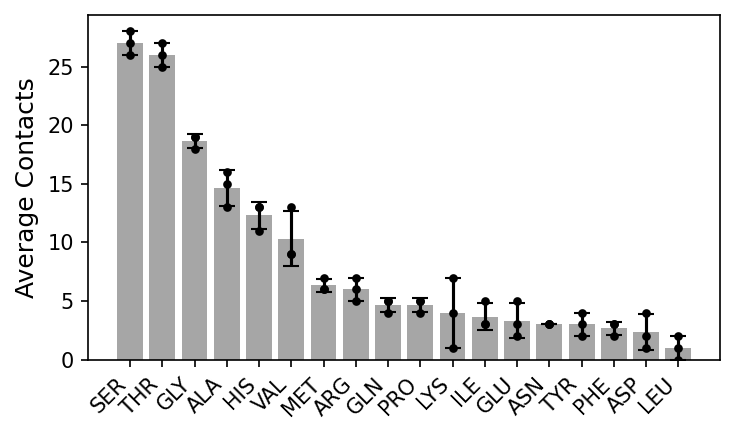

In [12]:
df_vals = df_per_type.drop(columns=['directory'])
means = df_vals.mean()
stds = df_vals.std()

# Sort by mean descending
means_sorted = means.sort_values(ascending=False)
stds_sorted = stds[means_sorted.index]
amino_acids = means_sorted.index

# Plot
plt.figure(figsize=(5, 3), dpi=150)
x = np.arange(len(amino_acids))

# Bars
plt.bar(x, means_sorted, yerr=stds_sorted, capsize=4, alpha=0.7, color='gray')

# Scatter individual values
for i, aa in enumerate(amino_acids):
    y_vals = df_vals[aa].values
    x_vals = np.full_like(y_vals, i, dtype=float)
    plt.scatter(x_vals, y_vals, color='black', s=10, alpha=1)

# Aesthetics
plt.xticks(x, amino_acids, rotation=45, ha='right', fontsize=10)
plt.ylabel("Average Contacts", fontsize=12)
plt.tight_layout()
plt.savefig('residue-lipid.pdf', format='pdf', dpi=400, transparent=True, bbox_inches='tight')
plt.show()

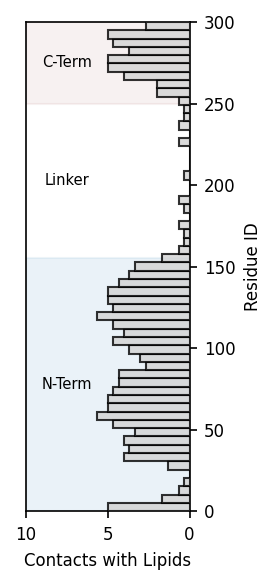

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_per_residue['resid'] = pd.to_numeric(df_per_residue['resid'])

bins = np.linspace(0, 300, 60)  # 40 bins between 0 and 300
bin_centers = 0.5 * (bins[:-1] + bins[1:])

histograms = []
for directory in df_per_residue['directory'].unique():
    subset = df_per_residue[df_per_residue['directory'] == directory]
    counts, _ = np.histogram(subset['resid'], bins=bins)
    histograms.append(counts)

hist_array = np.array(histograms)
mean_hist = hist_array.mean(axis=0)
std_hist = hist_array.std(axis=0)

# Plot
plt.figure(figsize=(2, 4), dpi=150)
plt.barh(bin_centers, mean_hist, height=(bins[1] - bins[0]), color='lightgray', alpha=0.8, edgecolor='k', zorder=4)

plt.axhspan(0, 155, color='#3688bb', alpha=0.1)  # N-Term
plt.axhspan(155, 250, color='white', alpha=0.1)  # Linker
plt.axhspan(250, 300, color='#b57979', alpha=0.1)  # C-Term

plt.text(7.5, (0 + 155) / 2, 'N-Term', va='center', ha='center', fontsize=7, rotation=0)
plt.text(7.5, (155 + 250) / 2, 'Linker', va='center', ha='center', fontsize=7, rotation=0)
plt.text(7.5, (250 + 300) / 2, 'C-Term', va='center', ha='center', fontsize=7, rotation=0)

plt.ylim(0, 300)
plt.xlim(0, 10)
plt.xlabel("Contacts with Lipids", fontsize=8)
plt.tick_params(labelsize=8)

ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_ylabel("Residue ID", fontsize=8)
ax.invert_xaxis()

plt.tight_layout()
plt.savefig('nodes-lipids-vertical.pdf', format='pdf', dpi=400, transparent=True, bbox_inches='tight')
plt.show()